## Aim

The prevalence of the interneuron hub mircorcircuit led us to the hypothesis that the interneurons mediate lateral inhibition. For effective lateral inhibition, the more active excitatory neuron has to be less sensitive to the inhibitory inputs than the less active one. This difference in sensitivity could stem from the timing of inhibition. The more active neuron is more likely to produce a spike in the interneuron, so that it receives the inhibition at a short time after spiking. In contrast, the less active neuron has a high chance to receive the inhibition in a later phase. How this timing of inhibition translates into sensitivity depends on the neuron model. Generally, however, most neuron models are less senstive to input directly after the spike than input in the middle of the phase.

We demonstrated the lateral inhibition with a model of Hodgkin-Huxley dynamics. Here, one important factor for the difference in senstivity is the relatively strong after-hyperpolarisation. When the membrane is hyperpolarised, inhibitory conductances cannot further inhibit the neuron, so that their effect is diminished. However, most pyramidal cells exhibit a reduced after-hyperpolarisation. Therefore, we would like to test the robustness of our results in more pyramidal-like neuron models.

For a different neuron model, I read Pospischil, 2008, an article claiming to provide model classes for four different neuron types (regular spiking, fast spiking, bursting and low threshold spiking). However, for their model fitting, they focus more on **spike timing** ("The error function consisted of a weighted sum over the absolute value of the differences in the time of the first spike after DC onset, the first, second and last interspike intervals, all values taken at three different DC levels" and "In order to avoid that an (experimentally) unreliable feature strongly impacts on the error function, we chose the weights wi to be the inverse of the SD of the experimental values. Large SDs thus lead to a reduced contribution to the error. However, in order to prevent an error that predomi-nantly consists of the contribution of a very reliable feature, we introduced a cut-off: whenever the SD of a given feature was smaller than 3% of the mean experimental value, the weight was taken as the inverse of these 3%, rather than as the inverse of the SD itself."). In almost all figures, there is a clear difference between the experimentally observed spike shapes and the modelled ones. 

1. Pospischil, M. et al. Minimal Hodgkin-Huxley type models for different classes of cortical and thalamic neurons. Biol. Cybern. 99, 427–441 (2008).


#### Brian2Model Fitting
I thought one interesting route could be to use Yanfangs recordings to do a custom fitting that puts more emphasis on the spike shape. For this reason, I will try the [Brian2 model fitting toolbox](https://brian2modelfitting.readthedocs.io/en/stable/index.html).

Installation

pip install brian2modelfitting did not work for me, because I did not get the right nevergrad version, which was related to this bug https://github.com/brian-team/brian2modelfitting/issues/24. So I cloned the repro and installed it from there.

#### Allen Cell Database

Another source of electrophysiological data is the [allen cell database](https://celltypes.brain-map.org/overview). They got cells from both human and mouse brain. What is nice is that they got their own fitting procedure, which allows to test and compare the fitting procedures used here. 

Stimuliwise, they applied a whole range of stimuli (long square pulses, white noise, ramp up). Interestingly, some cells show stuttering, which means that maybe the database could provide material to study bifurcations.


Browsing, I selected two cells for testing, one with 
- a [prinicpal cell like firing pattern](https://celltypes.brain-map.org/experiment/electrophysiology/327962063)
- an [interneuron like firing pattern](https://celltypes.brain-map.org/experiment/electrophysiology/485184849). 

What I need to know to proceed is 
* how to download and access the data? (use the prvoided [SDK](http://alleninstitute.github.io/AllenSDK/cell_types.html))
* how did they select the channels for fitting (read white papers)
* test fitting with current model



# Artficial data

## Generate target dynamics

In [1]:
from brian2.units import *
import brian2 as br

In [2]:
area = 20000 * umetre ** 2
hodgkin_huxley_params = {
    "Cm": 1 * ufarad * cm ** -2 * area,
    "gl": 5e-5 * siemens * cm ** -2 * area,
    "El": -65 * mV,
    "EK": -80 * mV,
    "ENa": 50 * mV,
    "g_na": 100 * msiemens * cm ** -2 * area,
    "g_kd": 30 * msiemens * cm ** -2 * area,
    "VT": -63 * mV
}

hodgkin_huxley_eqs = '''
dv/dt = (gl*(El-v) - g_na*(m*m*m)*h*(v-ENa) - g_kd*(n*n*n*n)*(v-EK) + I )/Cm : volt
dm/dt = 0.32*(mV**-1)*(13.*mV-v+VT)/
    (exp((13.*mV-v+VT)/(4.*mV))-1.)/ms*(1-m)-0.28*(mV**-1)*(v-VT-40.*mV)/
    (exp((v-VT-40.*mV)/(5.*mV))-1.)/ms*m : 1
dn/dt = 0.032*(mV**-1)*(15.*mV-v+VT)/
    (exp((15.*mV-v+VT)/(5.*mV))-1.)/ms*(1.-n)-.5*exp((10.*mV-v+VT)/(40.*mV))/ms*n : 1
dh/dt = 0.128*exp((17.*mV-v+VT)/(18.*mV))/ms*(1.-h)-4./(1+exp((40.*mV-v+VT)/(5.*mV)))/ms*h : 1
'''

I_eqs = '''
I: amp'''

In [3]:
inputs = [0.2*nA, 0.5*nA]
dt = 0.1*ms
duration = 100*ms

br.brian_prefs.dt = dt 
number_of_inputs = len(inputs)

neuron = br.NeuronGroup(N=number_of_inputs, model=hodgkin_huxley_eqs+I_eqs, method="exponential_euler", threshold="v>-40*mV", refractory="v>-40*mV")

trace_monitor = br.StateMonitor(neuron, ['v'], record=True)
net = br.Network(neuron)
net.run(100*ms, namespace=hodgkin_huxley_params)

v_eq = neuron.v[0]
m_eq = neuron.m[0]
h_eq = neuron.h[0]
n_eq = neuron.n[0]

net.add(trace_monitor)
for neuron_idx in range(number_of_inputs):
    neuron.I[neuron_idx]=inputs[neuron_idx]
    
net.run(duration,namespace=hodgkin_huxley_params)


In [4]:
import matplotlib.pyplot as plt

(100, 200)

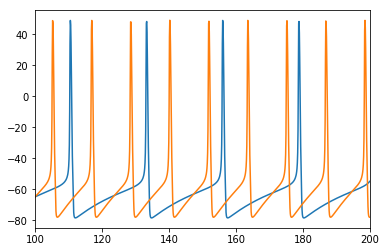

In [5]:
for idx in range(number_of_inputs):
    plt.plot(trace_monitor.t/ms, trace_monitor.v[idx][:]/mV)
plt.xlim(100, 200)

In [6]:
output_traces = trace_monitor.v[:]

In [7]:
output_traces.shape

(2, 1000)

In [8]:
import numpy as np

In [9]:
input_traces = np.repeat(np.array([inputs]), output_traces.shape[1], axis=0).T*amp

In [10]:
input_traces.shape

(2, 1000)

## Fit to target dynamics

In [11]:
import brian2modelfitting as mf

WARNING    /home/pfeiffer/.local/lib/python3.7/site-packages/tqdm-4.31.1-py3.7.egg/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)
 [py.warnings]


In [12]:
parameter_eqs = '''
g_na : siemens (constant)
g_kd : siemens (constant)
ENa: volt (constant)
EK: volt (constant)
'''

Cm =  1 * ufarad * cm ** -2 * area
gl =  5e-5 * siemens * cm ** -2 * area
El =  -65 * mV
VT =  -63 * mV

In [13]:
fitter = mf.TraceFitter(dt=0.1*ms,
                        model=hodgkin_huxley_eqs+parameter_eqs,
                        input_var="I",
                        output_var="v",
                        input=input_traces,
                        output=output_traces,
                        method='exponential_euler',
                        n_samples = 10,
                        param_init={"v":v_eq, "m": m_eq, "n": n_eq, "h": h_eq})

In [14]:
opt = mf.NevergradOptimizer(num_workers=3)
metric = mf.MSEMetric()

In [15]:
res, error = fitter.fit(n_rounds = 100, optimizer=opt, metric=metric, g_na=[0.33*hodgkin_huxley_params["g_na"], 3*hodgkin_huxley_params["g_na"]], g_kd = [0.33*hodgkin_huxley_params["g_kd"], 3*hodgkin_huxley_params["g_kd"]], ENa = [0.33*hodgkin_huxley_params["ENa"], 3*hodgkin_huxley_params["ENa"]], EK = [ 3*hodgkin_huxley_params["EK"], 0.33*hodgkin_huxley_params["EK"]])

Round 0: Best parameters EK=-80.72970268 mV, ENa=93.28475067 mV, g_kd=11.94292419 uS, g_na=18.65090046 uS (error: 535.13167236 mV^2)
Round 1: Best parameters EK=-80.72970268 mV, ENa=93.28475067 mV, g_kd=11.94292419 uS, g_na=18.65090046 uS (error: 535.13167236 mV^2)
Round 2: Best parameters EK=-80.72970268 mV, ENa=93.28475067 mV, g_kd=11.94292419 uS, g_na=18.65090046 uS (error: 535.13167236 mV^2)
Round 3: Best parameters EK=-79.93536198 mV, ENa=98.90291024 mV, g_kd=4.90649368 uS, g_na=12.4663984 uS (error: 521.20696045 mV^2)
Round 4: Best parameters EK=-79.27860726 mV, ENa=90.67703194 mV, g_kd=4.02634386 uS, g_na=10.23542998 uS (error: 443.4301886 mV^2)
Round 5: Best parameters EK=-79.27860726 mV, ENa=90.67703194 mV, g_kd=4.02634386 uS, g_na=10.23542998 uS (error: 443.4301886 mV^2)
Round 6: Best parameters EK=-79.27860726 mV, ENa=90.67703194 mV, g_kd=4.02634386 uS, g_na=10.23542998 uS (error: 443.4301886 mV^2)
Round 7: Best parameters EK=-79.27860726 mV, ENa=90.67703194 mV, g_kd=4.02634

Round 64: Best parameters EK=-80.57629328 mV, ENa=92.3130725 mV, g_kd=3.36284425 uS, g_na=13.35824019 uS (error: 106.929503 mV^2)
Round 65: Best parameters EK=-80.57629328 mV, ENa=92.3130725 mV, g_kd=3.36284425 uS, g_na=13.35824019 uS (error: 106.929503 mV^2)
Round 66: Best parameters EK=-80.57629328 mV, ENa=92.3130725 mV, g_kd=3.36284425 uS, g_na=13.35824019 uS (error: 106.929503 mV^2)
Round 67: Best parameters EK=-80.57629328 mV, ENa=92.3130725 mV, g_kd=3.36284425 uS, g_na=13.35824019 uS (error: 106.929503 mV^2)
Round 68: Best parameters EK=-80.16013747 mV, ENa=104.25254492 mV, g_kd=3.73747797 uS, g_na=12.65996397 uS (error: 85.0442541 mV^2)
Round 69: Best parameters EK=-80.16013747 mV, ENa=104.25254492 mV, g_kd=3.73747797 uS, g_na=12.65996397 uS (error: 85.0442541 mV^2)
Round 70: Best parameters EK=-80.16013747 mV, ENa=104.25254492 mV, g_kd=3.73747797 uS, g_na=12.65996397 uS (error: 85.0442541 mV^2)
Round 71: Best parameters EK=-80.16013747 mV, ENa=104.25254492 mV, g_kd=3.73747797 u

In [16]:
res

{'ENa': 116.05993741 * mvolt,
 'EK': -79.80793375 * mvolt,
 'g_kd': 5.20046815 * usiemens,
 'g_na': 12.63195592 * usiemens}

In [17]:
for key in res.keys():
    print("{:s}: {} (target) {} (fit)".format(key, hodgkin_huxley_params[key], res[key]))

ENa: 0.05 (target) 0.11605993741166562 (fit)
EK: -0.08 (target) -0.07980793374984355 (fit)
g_kd: 6e-06 (target) 5.200468147161877e-06 (fit)
g_na: 2e-05 (target) 1.2631955922035222e-05 (fit)


In [18]:
hodgkin_huxley_params["g_na"]

20. * usiemens

In [19]:
hodgkin_huxley_params["g_kd"]

6. * usiemens

In [20]:
traces = fitter.generate_traces()

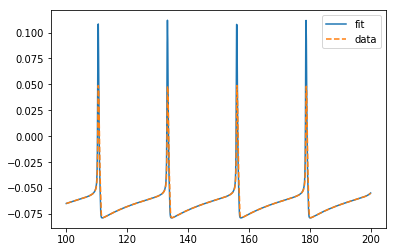

In [21]:
plt.plot(trace_monitor.t/ms, traces[0,:], label="fit")
plt.plot(trace_monitor.t/ms, output_traces[0,:], linestyle= '--', label="data")
plt.legend()

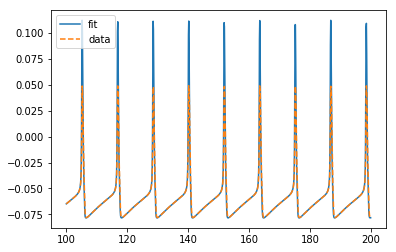

In [22]:
plt.plot(trace_monitor.t/ms, traces[1,:], label="fit")
plt.plot(trace_monitor.t/ms, output_traces[1,:], linestyle= '--', label="data")
plt.legend()

# Real traces

In [23]:
from allensdk.core.cell_types_cache import CellTypesCache
import numpy as np
import matplotlib.pyplot as plt
from brian2.units import *

In [24]:
ctc = CellTypesCache(manifest_file='../../alleninstitute_cell_db/manifest.json')

excitatory_neuron_test_id = 327962063

data_set = ctc.get_ephys_data(excitatory_neuron_test_id)

In [25]:
for sweep_id in data_set.get_experiment_sweep_numbers():
    print(sweep_id)
    print(data_set.get_sweep_metadata(sweep_id))
    print()

WARNING    /home/pfeiffer/Applications/miniconda2/envs/interneuron_polarity/lib/python3.7/site-packages/allensdk/core/nwb_data_set.py:386: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  sweep_metadata[field] = stim_details[field].value
 [py.warnings]


10
{'aibs_stimulus_amplitude_pa': 400.0, 'aibs_stimulus_name': 'Short Square', 'gain': 0.01, 'initial_access_resistance': 18.771164, 'seal': 1.31769}

11
{'aibs_stimulus_amplitude_pa': 350.0, 'aibs_stimulus_name': 'Short Square', 'gain': 0.01, 'initial_access_resistance': 18.771164, 'seal': 1.31769}

12
{'aibs_stimulus_amplitude_pa': 370.0, 'aibs_stimulus_name': 'Short Square', 'gain': 0.01, 'initial_access_resistance': 18.771164, 'seal': 1.31769}

14
{'aibs_stimulus_amplitude_pa': 380.0, 'aibs_stimulus_name': 'Short Square', 'gain': 0.01, 'initial_access_resistance': 18.771164, 'seal': 1.31769}

15
{'aibs_stimulus_amplitude_pa': 390.0, 'aibs_stimulus_name': 'Short Square', 'gain': 0.01, 'initial_access_resistance': 18.771164, 'seal': 1.31769}

16
{'aibs_stimulus_amplitude_pa': 390.0, 'aibs_stimulus_name': 'Short Square', 'gain': 0.01, 'initial_access_resistance': 18.771164, 'seal': 1.31769}

18
{'aibs_stimulus_amplitude_pa': 390.0, 'aibs_stimulus_name': 'Short Square', 'gain': 0.01, '

In [26]:
all_sweep_ids = data_set.get_experiment_sweep_numbers()
long_square_sweep_ids = list(filter(lambda sweep_id: data_set.get_sweep_metadata(sweep_id)["aibs_stimulus_name"] == "Long Square", all_sweep_ids))


In [27]:
sweeps_with_spiking = list(filter(lambda sweep_id: len(data_set.get_spike_times(sweep_id))>0, long_square_sweep_ids))

WARNING    /home/pfeiffer/Applications/miniconda2/envs/interneuron_polarity/lib/python3.7/site-packages/allensdk/core/nwb_data_set.py:255: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  return f[ds].value
 [py.warnings]


In [28]:
sweeps_with_spiking

[28, 29, 30, 31, 32, 33, 34, 35, 37, 38, 39]

WARNING    /home/pfeiffer/Applications/miniconda2/envs/interneuron_polarity/lib/python3.7/site-packages/allensdk/core/nwb_data_set.py:108: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  stimulus = stimulus_dataset.value
 [py.warnings]
WARNING    /home/pfeiffer/Applications/miniconda2/envs/interneuron_polarity/lib/python3.7/site-packages/allensdk/core/nwb_data_set.py:109: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  response = swp['response']['timeseries']['data'].value
 [py.warnings]
WARNING    /home/pfeiffer/Applications/miniconda2/envs/interneuron_polarity/lib/python3.7/site-packages/allensdk/core/nwb_data_set.py:125: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  swp_idx_start = swp['stimulus']['idx_start'].value
 [py.warnings]
WARNING    /home/pfeiffer/Applications/miniconda2/envs/interneuron_polarity/lib/python3.7/site-packages/allensdk/core/nwb_data_set.py:126: H

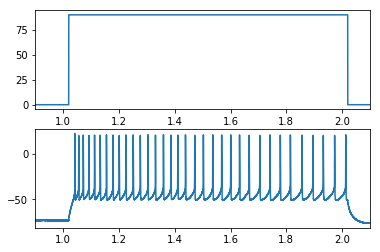

In [29]:
sweep_id = sweeps_with_spiking[2]

sweep_data = data_set.get_sweep(sweep_id)
sweep_len = sweep_data["index_range"][1]

ts = np.arange(0, sweep_len+1) * 1.0/sweep_data["sampling_rate"]
current = sweep_data["stimulus"][:]*1e12
voltage = sweep_data["response"][:]*1e3

fig,axes = plt.subplots(2,1)
axes[0].plot(ts, current)
axes[1].plot(ts, voltage)

for ax in axes:
    ax.set_xlim(0.9, 2.1)


### Test data

In [30]:
sampling_rate = sweep_data["sampling_rate"]
start_idx = int(0.8*sweep_data["sampling_rate"])
end_idx = int(2.2*sweep_data["sampling_rate"])


In [31]:
def get_input_trace(sweep_id):
    sweep_data = data_set.get_sweep(sweep_id)
    return sweep_data["stimulus"][:]

def get_output_trace(sweep_id):
    sweep_data = data_set.get_sweep(sweep_id)
    return sweep_data["response"][:]

selected_sweeps = [28, 29, 30]
    
input_traces = [get_input_trace(sweep_id)[start_idx:end_idx] for sweep_id in selected_sweeps]
output_traces = [get_output_trace(sweep_id)[start_idx:end_idx] for sweep_id in selected_sweeps]

In [32]:
input_traces_as_array = np.vstack(tuple(input_traces))*amp
output_traces_as_array = np.vstack(tuple(output_traces))*volt

### Test fitting with trace

In [33]:
import brian2modelfitting as mf

In [34]:
area = 20000 * umetre ** 2
parameter_eqs = '''
g_na : siemens (constant)
g_kd : siemens (constant)
ENa: volt (constant)
EK: volt (constant)
'''

Cm =  1 * ufarad * cm ** -2 * area
gl =  5e-5 * siemens * cm ** -2 * area
El =  -65 * mV
VT =  -63 * mV

In [37]:
fitter = mf.TraceFitter(dt=1.0/(sampling_rate*hertz),
                        model=hodgkin_huxley_eqs+parameter_eqs,
                        input_var="I",
                        output_var="v",
                        input=input_traces_as_array,
                        output=output_traces_as_array,
                        method='exponential_euler',
                        n_samples = 10,
                        param_init={"v":v_eq, "m": m_eq, "n": n_eq, "h": h_eq})

In [38]:
opt = mf.NevergradOptimizer(num_workers=3)
metric = mf.MSEMetric()

In [39]:
res, error = fitter.fit(n_rounds = 3, optimizer=opt, metric=metric, g_na=[0.33*hodgkin_huxley_params["g_na"], 3*hodgkin_huxley_params["g_na"]], g_kd = [0.33*hodgkin_huxley_params["g_kd"], 3*hodgkin_huxley_params["g_kd"]], ENa = [0.33*hodgkin_huxley_params["ENa"], 3*hodgkin_huxley_params["ENa"]], EK = [ 3*hodgkin_huxley_params["EK"], 0.33*hodgkin_huxley_params["EK"]])

Round 0: Best parameters EK=-75.94370134 mV, ENa=101.09358748 mV, g_kd=9.77489769 uS, g_na=40.02886521 uS (error: 490.68526208 mV^2)
Round 1: Best parameters EK=-79.96226185 mV, ENa=81.74897498 mV, g_kd=8.86173338 uS, g_na=32.28912981 uS (error: 467.78003885 mV^2)
Round 2: Best parameters EK=-79.96226185 mV, ENa=81.74897498 mV, g_kd=8.86173338 uS, g_na=32.28912981 uS (error: 467.78003885 mV^2)


In [40]:
fitted_traces = fitter.generate_traces()

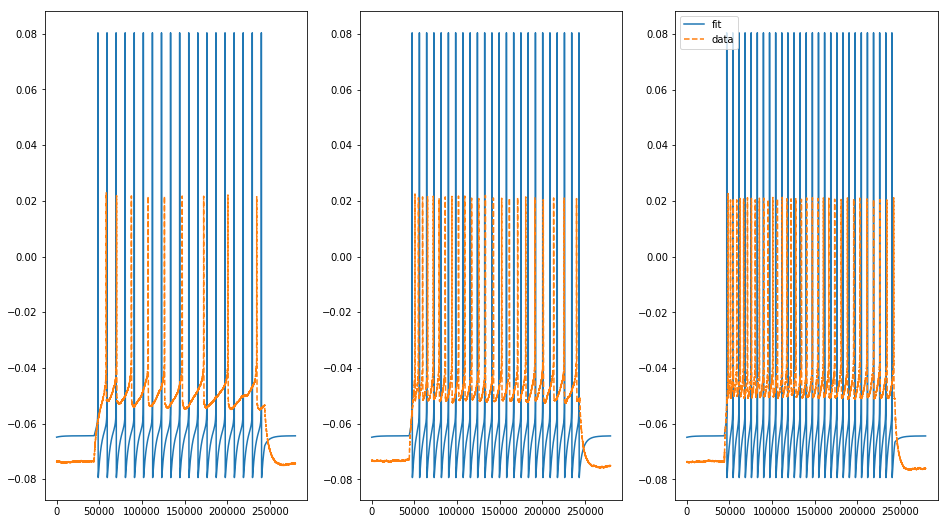

In [54]:
fig, axes = plt.subplots(1, len(selected_sweeps), figsize=(16, 9))
for idx, ax in enumerate(axes):
    ax.plot( fitted_traces[idx,:], label="fit")
    ax.plot( output_traces_as_array[idx,:], linestyle= '--', label="data")
axes[-1].legend()

Some obs:
- the data shows spike trains on top of a relatively high plateau, this could be due to morphology, if the axon was remote
- passive data like leak and capacitance could be taken from subthreshold data
- how do they choose the ionic currents to fit